In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from IPython.display import display, HTML

import numpy as np 
import pandas as pd
import cv2
import math

import os
from pathlib import Path

import time
from datetime import datetime

from histogram import *
from imagereader import *
#from data_explorer import *


In [3]:
def writePng(im,file):
    file.parent.mkdir(parents=True, exist_ok=True)
    cv2.imwrite(str(file), (255.0*cv2.cvtColor(im,cv2.COLOR_RGB2BGR) + 0.5).astype(np.uint8))
def channelStat(im):
         return np.mean(im[:,:,0]), np.mean(im[:,:,1]), np.mean(im[:,:,2]), np.std(im[:,:,0]), np.std(im[:,:,1]), np.std(im[:,:,2])
def genEqualization(pathTrg, files, nbCommon, eqc):
    filenames, testOrTrain, hSrcAll,hTrgAll, chStatSrc, chStatTrg = [],[],[],[],[],[]
    middelBins = None
    for f in files:
        testOrTrain.append( f.parts[nbCommon] )

        fTrg = pathTrg.joinpath(*f.parts[nbCommon:])
    
        imSrc= ImageColors(reader.open(f), eqc)    
        hSrc  = Histogram.fromBinIntervals(histType,imSrc.V.flatten(),vmin,vmax,nBins)
        
        imTrg = ImageColors(imSrc.im.copy(), eqc)    
        imTrg.V = hSrc.equalize(imTrg.V)
        
        writePng(imTrg.im,fTrg)
        
        if middelBins is None: middelBins = hSrc.middelBins
        
        filenames.append(Path(f.stem).name)
        hSrcAll.append(hSrc.hist)        
        chStatSrc.append(channelStat(imSrc.im))
        
        hTrg  = Histogram.fromBinIntervals(histType,imTrg.V.flatten(),vmin,vmax,nBins)
        hTrgAll.append(hTrg.hist)
        chStatTrg.append(channelStat(imTrg.im))
        
    cols        =  list( map(str,np.round(middelBins,6)) )
    dfSrcAll    = pd.DataFrame(index=filenames, data = np.asarray(hSrcAll), columns=cols ) 
    dfSrcAll.insert(0,"testOrTrain","", allow_duplicates=True)
    dfSrcAll.testOrTrain = np.asarray(testOrTrain)

    dfTrgAll    = pd.DataFrame(index=filenames, data = np.asarray(hTrgAll), columns=cols ) 
    dfTrgAll.insert(0,"testOrTrain",testOrTrain)
    dfTrgAll.testOrTrain = np.asarray(testOrTrain)
    
    dfchStatSrc = pd.DataFrame(index=filenames, data = np.asarray(chStatSrc), columns=["rMean","gMean","bMean","rSD","gSD","bSD"] ) 
    dfchStatTrg = pd.DataFrame(index=filenames, data = np.asarray(chStatTrg), columns=dfchStatSrc.columns ) 
    return filenames, dfSrcAll,dfTrgAll,dfchStatSrc,dfchStatTrg

def saveHistograms(path, filenames, bins, dfh):
    #cols   = np.round(bins,6)
    #dfh    = pd.DataFrame(index=filenames, data = np.asarray(hl), columns=cols ) 
    dfh.to_csv(path / "histograms.csv" )
    
    mHist  = dfh.mean(axis=0).values
    sdHist = dfh.std(axis=0).values
    dfhm   = pd.DataFrame( data = np.stack([bins, mHist, sdHist],axis=-1), columns=["bins", "mean_","std_"] ) 
    dfhm.to_csv(path / "histograms-mean-std.csv" )
    return dfhm

def saveChannelStats( path, dfChStat ):
    dfChStat.to_csv(path / "channelstats.csv" )
    dfm   = pd.DataFrame( columns=dfChStat.columns ) 
    dfm.loc[0] = dfChStat.mean(axis=0).values
    dfm.to_csv(path / "channelstats means.csv", index=False )
    return dfm

from calcStatistics import *
def genSaveStats( path, bins ):
    dh = pd.read_csv(path/"histograms.csv", index_col=0)
    dh.drop("testOrTrain",axis=1,inplace=True)
    ds = calcStatistics(bins, dh)
    ds.to_csv(path/"histogram_statistics.csv" )    
    return ds

In [4]:
def printHist(histType, h):
    print(f"Hist {histType} len:{len(h.middelBins)}: \nbins", h.middelBins, "\nhist:", h.hist, "\ncdf:", h.cdf)   

eqc      = EQC.ALL
histType = HISTOGRAMTYPE.CLASSIC
vmin     = 1e-6
vmax     = 1.
nBins    = 64

print("Data:For imagenet - dog&cats")
commonPath = Path("../../../../fastai-data/data/") #coaraire
#commonPath = Path("../../../../fastai-data/data/") #coaraire
nbCommon   = len(commonPath.parts)+1
pathSrc    = commonPath / "cifar10"
pathTrg    = commonPath / f"cifar10-{histType.name}-{eqc.name}-channelmixing"
files      = list( pathSrc.glob("**/*.png") )
reader     = ImageReader()
print(f"Dataset: {pathSrc}  with {len(files)} files")


%time filenames, dfSrcAll, dfTrgAll,dfChStatSrc,dfChStatTrg = genEqualization(pathTrg, files, nbCommon, eqc)
bins = np.linspace(vmin,vmax,nBins)

dfSrcAll.testOrTrain.head()
dfSrcAll.groupby("testOrTrain").count()

Data:For imagenet - dog&cats
Dataset: ..\..\..\..\fastai-data\data\cifar10  with 60000 files
Wall time: 5min 41s


,1e-06,0.015874,0.031747,0.04762,0.063493,0.079366,0.095239,0.111112,0.126985,0.142858,...,0.857143,0.873016,0.888889,0.904762,0.920635,0.936508,0.952381,0.968254,0.984127,1.0
testOrTrain,,,,,,,,,,,,,,,,,,,,,
test,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,...,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
train,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,...,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000


In [5]:
dfSrcMSD = saveHistograms(pathSrc, filenames, bins, dfSrcAll)
dfChStatMeansSrc = saveChannelStats(pathSrc, dfChStatSrc)

dfTrgMSD = saveHistograms(pathTrg, filenames, bins, dfTrgAll)
dfChStatMeansTrg = saveChannelStats(pathTrg, dfChStatTrg)

print("dfChStatMeansSrc")
display(dfChStatMeansSrc)
print("\ndfChStatMeansTrg")
display(dfChStatMeansTrg)

dStatSrc = genSaveStats(pathSrc, bins)
dStatTrg = genSaveStats(pathTrg, bins)


dfChStatMeansSrc


,rMean,gMean,bMean,rSD,gSD,bSD
0,0.491868,0.482653,0.447176,0.202151,0.199268,0.200891



dfChStatMeansTrg


,rMean,gMean,bMean,rSD,gSD,bSD
0,0.537684,0.532053,0.470702,0.268645,0.269352,0.271793


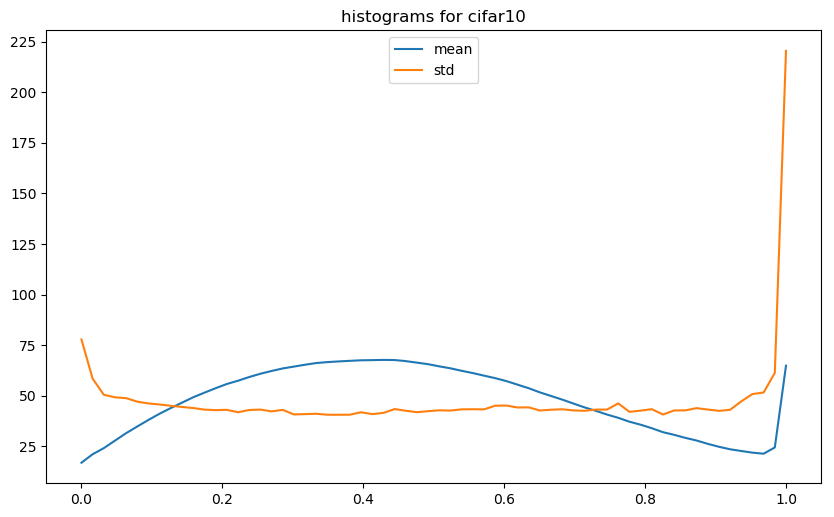

In [6]:
import matplotlib.pyplot as plt 
def plotmeanstd(title, bins, mean, std):
    fig,axes = plt.subplots(nrows=1, ncols=1, figsize = (10,6), dpi=100 )
    axes.set_title(title)
    axes.plot(bins, mean, label="mean" )
    axes.plot(bins, std,  label="std"  )

    #plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left', ncol=2, mode="expand", borderaxespad=0.)
    plt.legend(loc='upper center')

plotmeanstd(f"histograms for {pathSrc.stem}", dfSrcMSD.bins.values, dfSrcMSD.mean_.values, dfSrcMSD.std_.values)

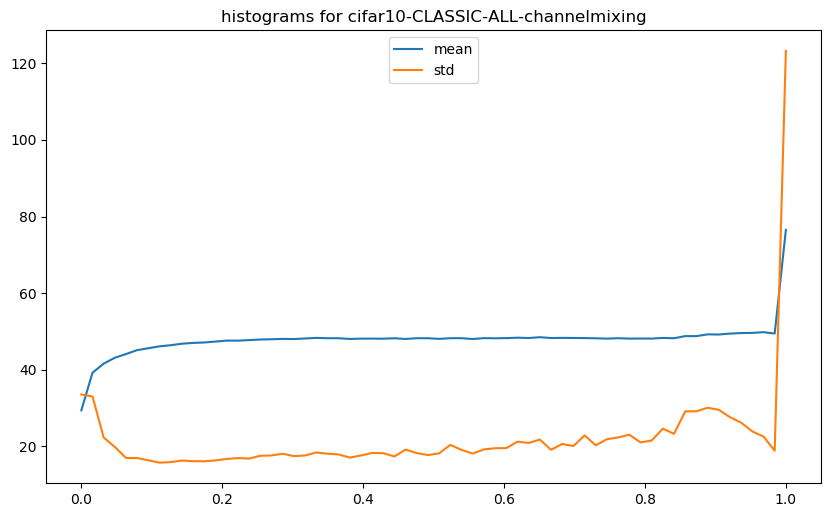

In [7]:
plotmeanstd(f"histograms for {pathTrg.stem}", dfTrgMSD.bins.values, dfTrgMSD.mean_.values, dfTrgMSD.std_.values)